# species occurances

Let's see if we can build a cohesive model using just the training dataset.

In [2]:
prefix = "gs://dsgt-clef-geolifeclef-2024"
# ! gcloud storage ls {prefix}/data/raw
! gcloud storage du --readable-sizes {prefix}/data/raw/Presence_Absence_surveys/
! gcloud storage du --readable-sizes {prefix}/data/raw/Presence_only_occurrences/

10.72MiB     gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/Presences_Absences_train.csv
2.85kiB      gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/Readme.txt
2.08MiB      gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/enviroTab_pa_train.csv
1.05MiB      gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/train_pa_spAround_1km.csv
385.15kiB    gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/train_pred_maxent_on_PA.csv
14.23MiB     gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/
617.02MiB    gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_only_occurrences/Presences_only_train.csv
1.49kiB      gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_only_occurrences/Readme.txt
617.03MiB    gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_only_occurrences/


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from geolifeclef.utils import get_spark
from pyspark.sql import functions as F

prefix = "gs://dsgt-clef-geolifeclef-2024"

spark = get_spark()
df = spark.read.csv(
    f"{prefix}/data/raw/Presence_only_occurrences/Presences_only_train.csv",
    header=True,
    sep=";",
    inferSchema=True,
)
df = df.cache()
df.printSchema()
df.show(n=1, vertical=True, truncate=80)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/15 23:36:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/15 23:36:43 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/02/15 23:36:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/02/15 23:36:44 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


root
 |-- glcID: integer (nullable = true)
 |-- gbifID: double (nullable = true)
 |-- observer: string (nullable = true)
 |-- datasetName: string (nullable = true)
 |-- date: date (nullable = true)
 |-- dayOfYear: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- lon: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- x_EPSG3035: double (nullable = true)
 |-- y_EPSG3035: double (nullable = true)
 |-- geoUncertaintyInM: double (nullable = true)
 |-- speciesId: integer (nullable = true)
 |-- patchID: integer (nullable = true)
 |-- timeSerieID: integer (nullable = true)



-RECORD 0---------------------------
 glcID             | 2774863        
 gbifID            | 1.978418095E9  
 observer          | Jim Kingdon    
 datasetName       | iNaturalist RG 
 date              | 2018-09-29     
 dayOfYear         | 272            
 year              | 2018           
 lon               | -10.53904      
 lat               | 51.77186       
 x_EPSG3035        | 2924908.0      
 y_EPSG3035        | 3383275.0      
 geoUncertaintyInM | 4.0            
 speciesId         | 8075           
 patchID           | 3018869        
 timeSerieID       | 1000           
only showing top 1 row



In [5]:
df.count()

4908319

In [6]:
df.where("dayOfYear is null").count(), df.select(F.countDistinct("speciesId")).show()

+-------------------------+
|count(DISTINCT speciesId)|
+-------------------------+
|                    10038|
+-------------------------+



(0, None)

In [7]:
from math import pi

geotime_df = df.select(
    "lat",
    "lon",
    F.col("dayOfYear").alias("doy"),
    F.sin(2 * pi * F.col("dayOfYear") / 365.25).alias("sin_doy"),
    F.cos(2 * pi * F.col("dayOfYear") / 365.25).alias("cos_doy"),
    "speciesId",
)
geotime_df.show(n=5)

+--------+---------+---+--------------------+--------------------+---------+
|     lat|      lon|doy|             sin_doy|             cos_doy|speciesId|
+--------+---------+---+--------------------+--------------------+---------+
|51.77186|-10.53904|272| -0.9994446170919858|-0.03332352571163...|     8075|
|51.77226|-10.53875|234| -0.7731383255706026| -0.6342374393978054|     8075|
|52.11013|-10.47597|191| -0.1435724234118113| -0.9896398128792412|     6477|
|52.15074|-10.47555|183|-0.00645086419810515| -0.9999791929590823|     5783|
|52.10978|-10.47497|158|  0.4110537546870351| -0.9116111071930239|     9011|
+--------+---------+---+--------------------+--------------------+---------+
only showing top 5 rows



/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


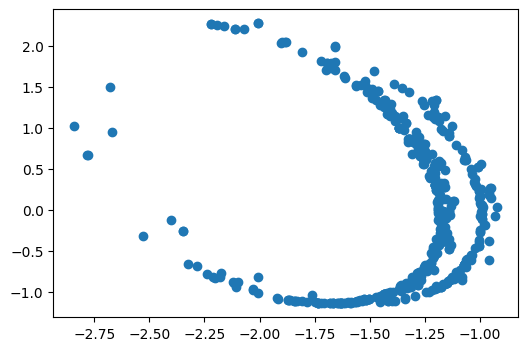

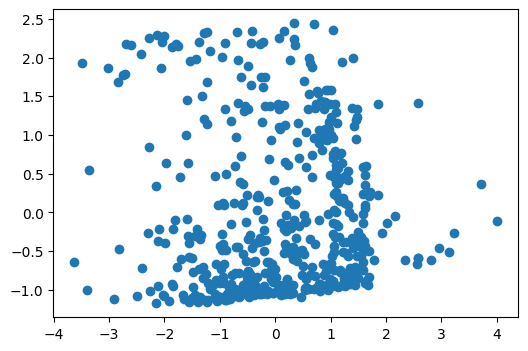

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

pdf = geotime_df.toPandas()

X = pdf[["lat", "lon", "sin_doy", "cos_doy"]]
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:500, 0], X_pca[:500, 1])
plt.show()

plt.figure(figsize=(6, 4))
# random rows
X_pca_sampled = X_pca[np.random.choice(X_pca.shape[0], 500, replace=False)]
plt.scatter(X_pca_sampled[:, 0], X_pca_sampled[:, 1])
plt.show()

# clean up
del pdf, X, X_pca, scaler, pca

How well does this data predict species?
Let's try this out using a very simple linear model first, and then try more complex variations.
We'll start off with using spark-ml, because the naive approach of using pandas and scikit-learn is certainly not going to work with this dataset.

In [10]:
# how good is this data for predicting species?
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

assembler = VectorAssembler(
    inputCols=["lat", "lon", "sin_doy", "cos_doy"],
    outputCol="features",
)
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True,
)
lr = LogisticRegression(
    labelCol="speciesId",
    featuresCol="scaled_features",
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8,
)
pipeline = Pipeline(stages=[assembler, scaler, lr])
# fit the model
model = pipeline.fit(geotime_df)
# make predictions
predictions = model.transform(geotime_df)
# evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="speciesId", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy = {accuracy}")

24/02/15 23:40:10 ERROR Executor: Exception in task 1.0 in stage 22.0 (TID 49)5]
java.lang.OutOfMemoryError: Java heap space
	at scala.reflect.ManifestFactory$DoubleManifest.newArray(Manifest.scala:194)
	at scala.reflect.ManifestFactory$DoubleManifest.newArray(Manifest.scala:191)
	at scala.Array$.ofDim(Array.scala:305)
	at org.apache.spark.ml.optim.aggregator.MultinomialLogisticBlockAggregator.add(MultinomialLogisticBlockAggregator.scala:114)
	at org.apache.spark.ml.optim.aggregator.MultinomialLogisticBlockAggregator.add(MultinomialLogisticBlockAggregator.scala:45)
	at org.apache.spark.ml.optim.loss.RDDLossFunction.$anonfun$calculate$1(RDDLossFunction.scala:59)
	at org.apache.spark.ml.optim.loss.RDDLossFunction$$Lambda$4651/0x0000000841b9f840.apply(Unknown Source)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala

Py4JError: py4j does not exist in the JVM

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
